In [2]:
import numpy as np, random, operator
import pandas as pd
import matplotlib.pyplot as plt

#  City

In [3]:
import numpy as np

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"


# Fitness

In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


In [5]:
def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        l = random.sample(cityList, len(cityList))
        population.append(l)
    return population

def rankRoutes(routes_population):
    fitnessResults = {}
    for i in range(0, len(routes_population)):
        fitnessResults[i] = Fitness(routes_population[i]).routeFitness()
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def selection(popRanked, eliteSize):
    selectionResults = []
    # Set up the roulette wheel by calculating a relative fitness weight for each individual.
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()

    # Pick top N (eliteSize) best routes to automatically move on to the next generation (elitism)
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])

    # Randomly pick candidates from the rest
    for i in range(eliteSize, len(popRanked)):
        pick = 100 * random.random()
        if pick <= df.iat[i, 3]:
            selectionResults.append(popRanked[i][0])

    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

# Ordered crossover
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]
    child = childP1 + childP2

    return child

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    # Keep the elites
    for i in range(0, eliteSize):
        children.append(matingpool[i])

    # Create offspring
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool) - i - 1])
        children.append(child)

    return children

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if random.random() < mutationRate:
            swapWith = int(random.random() * len(individual))
            city1 = individual[swapped]
            city2 = individual[swapWith]
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

def geneticAlgorithmPlot(routes_population, popSize, eliteSize, mutationRate, generations):
    progress = []
    progress.append(1 / rankRoutes(routes_population)[0][1])

    for i in range(0, generations):
        routes_population = nextGeneration(routes_population, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(routes_population)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

def geneticAlgorithm(routes_population, popSize, eliteSize, mutationRate, generations):
    ranked_Routes = rankRoutes(routes_population)
    bestRoute_1stGen = routes_population[ranked_Routes[0][0]]

    print("Initial distance: " + str(1 / ranked_Routes[0][1]))

    for i in range(0, generations):
        routes_population = nextGeneration(routes_population, eliteSize, mutationRate)

    print("Final distance: " + str(1 / rankRoutes(routes_population)[0][1]))

    bestRouteIndex = rankRoutes(routes_population)[0][0]
    bestRoute = routes_population[bestRouteIndex]

    return bestRoute_1stGen, bestRoute

def run(num_cities=10, pop_size=100, elite_size=10, mutationRate=0.0001, generations=1000):
    np.random.seed(10)
    cityList = []

    for i in range(0, num_cities):
        cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

    routes_population = []
    for i in range(0, pop_size):
        routes_population.append(random.sample(cityList, len(cityList)))

    firstGenBestRoute, lastGenBestRoute = geneticAlgorithm(routes_population,popSize=pop_size,eliteSize=elite_size,mutationRate=mutationRate,generations=generations)

    geneticAlgorithmPlot(routes_population, pop_size, elite_size, mutationRate, generations)

    # Plot the first generation's best route
    x_val = [x.x for x in firstGenBestRoute] + [firstGenBestRoute[0].x]
    y_val = [x.y for x in firstGenBestRoute] + [firstGenBestRoute[0].y]

    plt.plot(x_val, y_val)
    plt.plot(x_val, y_val, 'or')
    plt.title('First Generation Best Route')
    plt.show()

    # Plot the last generation's best route
    x_val = [x.x for x in lastGenBestRoute] + [lastGenBestRoute[0].x]
    y_val = [x.y for x in lastGenBestRoute] + [lastGenBestRoute[0].y]

    plt.plot(x_val, y_val)
    plt.plot(x_val, y_val, 'or')
    plt.title('Last Generation Best Route')
    plt.show()

Initial distance: 1767.6282899964222
Final distance: 1007.9567034751915


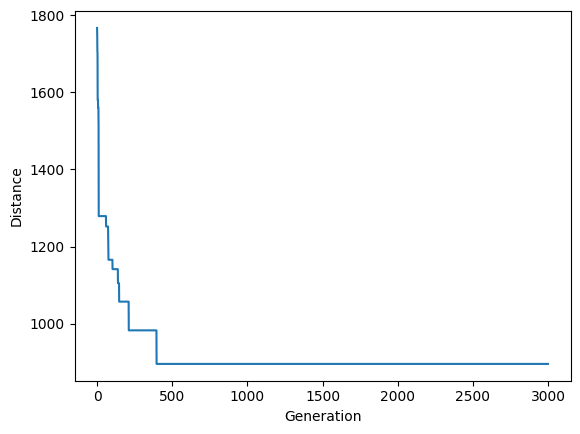

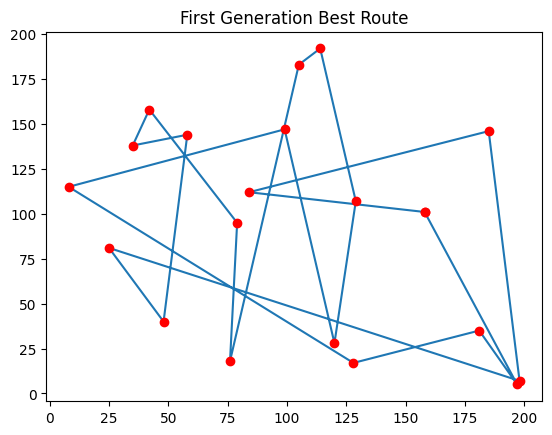

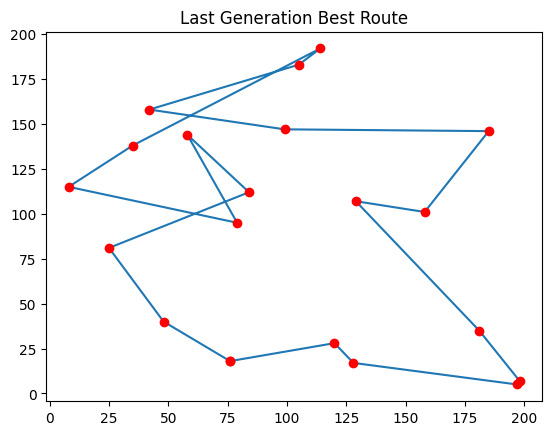

In [28]:
run(num_cities=20,pop_size=100,elite_size=10,mutationRate = 0.000001,generations = 3000)